# Recurrent Neural Networks classifier

## Imports

In [1]:
import os

from ipynb.fs.full.utils import *
import numpy as np
from numpy import interp
import gensim
from gensim.models import KeyedVectors
import pandas as pd
import pickle
import talos
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.metrics import Metric
from keras.layers import Dense, Flatten, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, f1_score, \
    classification_report, roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold

C:\Users\Mirijam\Desktop\rp-group-43-common\JupyterNotebooks\utils.ipynb:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
  "        label_list[i][j] = 1 if bool(is_detached[i]) == True else 0\n",
C:\Users\Mirijam\Desktop\rp-group-43-common\JupyterNotebooks\utils.ipynb:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
  "        label_list[i][j] = 1 if bool(is_detached[i]) == True else 0\n",
C:\Users\Mirijam\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mirijam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### List packages and their version numbers as used in this script

In [2]:
#list packages and their version numbers as used in this script (code is taken from 
#https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook)
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tensorflow==2.5.0
talos==1.0
scipy==1.5.2
scikit-learn==0.23.2
pandas==1.1.3
numpy==1.19.2
nltk==3.5
matplotlib==3.3.2
gensim==4.0.1
fasttext==0.9.2
contractions==0.0.49


### Set working directory

In [3]:
os.chdir("/Users/Mirijam/Desktop/rp-group-43-common/JupyterNotebooks")

## Global variables

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

schemas = ["vulnerable", "angry", "impulsive", "happy", "detached", "punishing", "healthy"]
max_length = 500
max_words = 2000
vec_size = 300
t = Tokenizer(num_words=max_words)

Num GPUs Available:  1


## BINARY dataset

In [5]:
# https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python
df = pd.read_csv("/Users/Mirijam/Desktop/rp-group-43-common/data/FINAL_CSV.csv",  encoding = "ISO-8859-1", engine='python')
# BINARY LABELS
texts, labels_binary = get_text_labels(df)

## ORDINAL dataset

In [6]:
# ORDINAL LABEL
_, labels_ordinal = get_average_for_each_label(df)

 ## Embedding matrix

In [7]:
# tokenizes and encodes the sentences.
def encode_and_pad(texts):
    print("ENCODING AND PADDING")
    t.fit_on_texts(texts)
    encoded_texts = t.texts_to_sequences(texts)
    return t, pad_sequences(encoded_texts, truncating="post", padding='post', maxlen=max_length)

# https://www.tensorflow.org/tutorials/text/word2vec#prepare_training_data_for_word2vec
def create_embedding_matrix(t):
    model = get_word2vec()
    print('PREPARING EMBEDDING MATRIX')
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, vec_size))
    for word, i in t.word_index.items():
        if model.__contains__(word):
            embedding_vector = model.__getitem__(word)
            embedding_matrix[i] = embedding_vector
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return vocab_size, embedding_matrix


## Splitting data

In [8]:
processed_texts, tokenized_texts = pre_process_data(texts)
t, padded_x = encode_and_pad(processed_texts)
print(processed_texts[0:5])
print(tokenized_texts[0:5])

# binary
padded_train_x_binary, train_y_binary, padded_test_x_binary, test_y_binary, percent_train_test_binary = split_data(padded_x, labels_binary, 0.2)
padded_train_x_binary, train_y_binary, padded_val_x_binary, val_y_binary, percent_train_val_binary = split_data(padded_train_x_binary, train_y_binary, 0.1)
print("train binary: ", np.shape(padded_train_x_binary))
print("val binary: ", np.shape(padded_val_x_binary))
print("test binary: ", np.shape(padded_test_x_binary))
# ordinal
padded_train_x_ordinal, train_y_ordinal, padded_test_x_ordinal, test_y_ordinal, percent_train_test_ordinal = split_data(padded_x, labels_ordinal, 0.2)
padded_train_x_ordinal, train_y_ordinal, padded_val_x_ordinal, val_y_ordinal, percent_train_val_ordinal = split_data(padded_train_x_ordinal, train_y_ordinal, 0.1)
print("train ordinal: ", np.shape(padded_train_x_ordinal))
print("val ordinal: ", np.shape(padded_val_x_ordinal))
print("test ordinal: ", np.shape(padded_test_x_ordinal))

# create embedding matrix
vocab_size, embedding_matrix = create_embedding_matrix(t)
print("embedding matrix: ", np.shape(embedding_matrix))
print("vocab_size: ", vocab_size)

ENCODING AND PADDING
['mother law colonoscopy today nerve wrecking could potentially discover bowel cancer also pandemic vulnerable catching covid 19 worried concerned well husband worried suffers anxiety worked everything I looking trying keep calm worst bit last night mother law take laxative preparation procedure lot pain stomach cramp horrible seeing agony tried look get thing needed distract felt bit useless felt sorry her', 'I worried mother law medical procedure seeing pain feel bad worried also husband worried her', 'elaborated', 'effective chatbot billy', 'live apart finacee love much left house two day ago return house going covid lockdown I sure see again make feel sad lonely miss greatly']
[['mother', 'law', 'colonoscopy', 'today', 'nerve', 'wrecking', 'could', 'potentially', 'discover', 'bowel', 'cancer', 'also', 'pandemic', 'vulnerable', 'catching', 'covid', '19', 'worried', 'concerned', 'well', 'husband', 'worried', 'suffers', 'anxiety', 'worked', 'everything', 'I', 'loo

## ORDINAL Results Measure

In [9]:
def get_results_ordinal(gof, preds):
    print('Ordinal Testset Output')
    print(pd.DataFrame(data=gof[0], index=schemas, columns=['estimate']))

## BINARY Grid Search Multilabel Model 

In [10]:
def fit_multilabel_model_binary(train_X, train_y, val_X, val_y, params):
    # build the model
    model = Sequential()
    e = Embedding(vocab_size, vec_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
    # embedding layer
    model.add(e)
    # LSTM layer
    model.add(Bidirectional(LSTM(params['lstm_units'])))
    # dropout layer
    model.add(Dropout(params['dropout']))
    # output layer
    model.add(Dense(7, activation='sigmoid'))
    # compile the model
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['mean_absolute_error'])
    # summarize the model
    print(model.summary())
    # fit the model
    out = model.fit(train_X, train_y,
                    validation_data=[val_X, val_y],
                    batch_size=params['batch_size'],
                    epochs=100,
                    verbose=0)
    return out, model

# https://stats.stackexchange.com/questions/207794/what-loss-function-for-multi-class-multi-label-classification-tasks-in-neural-n
# https://stackoverflow.com/questions/59336899/which-loss-function-and-metrics-to-use-for-multi-label-classification-with-very
# https://github.com/keras-team/keras/issues/741
# https://github.com/keras-team/keras/issues/10371
def grid_search_mlm_binary(train_X, val_X, train_y, val_y):
    # define hyperparameter grid
    p = {'lstm_units': [100, 200, 300],
         'optimizer': ['rmsprop', 'Adam'],
         'dropout': [0.1, 0.2, 0.5],
         'batch_size': [32, 64]}
    # scan the grid
    tal = talos.Scan(x=train_X,
                     y=train_y,
                     x_val=val_X,
                     y_val=val_y,
                     model=fit_multilabel_model_binary,
                     params=p,
                     experiment_name='fit_multilabel_model_binary',
                     print_params=True,
                     clear_session=True)
    return tal

Grid search binary multilabel model.

In [69]:
tal = grid_search_mlm_binary(padded_train_x_binary, padded_val_x_binary, train_y_binary, val_y_binary)
# analyze the outcome
analyze_object = talos.Analyze(tal)
analysis_results = analyze_object.data
# let's have a look at the results of the grid search
print(analysis_results)


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

{'batch_size': 32, 'dropout': 0.1, 'lstm_units': 100, 'optimizer': 'rmsprop'}
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 1407      
Total params: 1,689,307
Trainable params: 322,207
Non-trainable params: 1,367,100
_________________________________________________________________
None


KeyboardInterrupt: 

## BINARY Grid Search Per-Schema Model

In [70]:
def fit_psm_binary(train_X, train_y, val_X, val_y, params):
    model = Sequential()
    e = Embedding(vocab_size, vec_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model.add(e)
    model.add(Bidirectional(LSTM(params['lstm_units'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['mean_absolute_error'])
    # summarize the model
    print(model.summary())
    # fit the model
    out = model.fit(train_X, train_y,
              validation_data=[val_X, val_y],
              batch_size=params['batch_size'],
              epochs=100,
              verbose=0,
              use_multiprocessing=True)
    return out, model

def grid_search_psm_binary(train_X, val_X, train_y, val_y):
    # define hyperparameter grid
    p = {'lstm_units': [100, 200, 300],
         'optimizer': ['rmsprop', 'Adam'],
         'dropout': [0.1, 0.2, 0.5],
         'batch_size': [32, 64]}
    # scan the grid
    tal = talos.Scan(x=train_X,
                     y=train_y,
                     x_val=val_X,
                     y_val=val_y,
                     model=fit_psm_binary,
                     params=p,
                     experiment_name='fit_psm_binary',
                     print_params=True,
                     clear_session=True)
    return tal

In [72]:
for i in range(len(schemas)):
    tal = grid_search_psm_binary(padded_train_x_binary, padded_val_x_binary, train_y_binary[:, i], val_y_binary[:, i])
    # analyze the outcome
    analyze_object = talos.Analyze(tal)
    analysis_results = analyze_object.data
    # let's have a look at the results of the grid search
    print(analysis_results)

  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

{'batch_size': 32, 'dropout': 0.1, 'lstm_units': 100, 'optimizer': 'rmsprop'}
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 1,688,101
Trainable params: 321,001
Non-trainable params: 1,367,100
_________________________________________________________________
None


  0%|                                                                                           | 0/36 [00:35<?, ?it/s]


KeyboardInterrupt: 

## ORDINAL Grid Search Per-Schema Model

In [73]:
def fit_psm_ordinal(train_X, train_y, val_X, val_y, params):
    model = Sequential()
    e = Embedding(vocab_size, vec_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model.add(e)
    model.add(Bidirectional(LSTM(params['lstm_units'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(4, activation='softmax'))
    # compile the model
    model.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['mean_absolute_error'])
    # summarize the model
    print(model.summary())
    # fit the model
    out = model.fit(train_X, train_y,
              validation_data=[val_X, val_y],
              batch_size=params['batch_size'],
              epochs=100,
              verbose=0,
              use_multiprocessing=True)
    return out, model

def grid_search_psm_ordinal(train_X, val_X, train_y, val_y):
    # define hyperparameter grid
    p = {'lstm_units': [100, 200, 300],
         'optimizer': ['rmsprop', 'Adam'],
         'losses': ['categorical_crossentropy', 'mean_absolute_error'],
         'dropout': [0.1, 0.2, 0.5],
         'batch_size': [32, 64]}
    # scan the grid
    tal = talos.Scan(x=train_X,
                     y=train_y,
                     x_val=val_X,
                     y_val=val_y,
                     model=fit_psm_ordinal,
                     params=p,
                     experiment_name='fit_psm_ordinal',
                     print_params=True,
                     clear_session=True)
    return tal

In [74]:
for i, schema in enumerate(schemas):
    print(schema)
    train_label_schema = np_utils.to_categorical(train_y_ordinal[:, i], num_classes=4)
    val_label_schema = np_utils.to_categorical(val_y_ordinal[:, i], num_classes=4)
    tal = grid_search_psm_ordinal(padded_train_x_ordinal, padded_val_x_ordinal, train_label_schema, val_label_schema)
    # analyze the outcome
    analyze_object = talos.Analyze(tal)
    analysis_results = analyze_object.data
    # let's have a look at the results of the grid search
    print(analysis_results)


  0%|                                                                                           | 0/72 [00:00<?, ?it/s]

vulnerable
{'batch_size': 32, 'dropout': 0.1, 'losses': 'categorical_crossentropy', 'lstm_units': 100, 'optimizer': 'rmsprop'}
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 804       
Total params: 1,688,704
Trainable params: 321,604
Non-trainable params: 1,367,100
_________________________________________________________________
None


  0%|                                                                                           | 0/36 [01:33<?, ?it/s]

  1%|█                                                                               | 1/72 [02:57<3:29:37, 177.14s/it]

{'batch_size': 32, 'dropout': 0.1, 'losses': 'categorical_crossentropy', 'lstm_units': 100, 'optimizer': 'Adam'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 1,688,704
Trainable params: 321,604
Non-trainable params: 1,367,100
_________________________________________________________________
None



  3%|██▏                                                                             | 2/72 [05:49<3:25:01, 175.74s/it]

{'batch_size': 32, 'dropout': 0.1, 'losses': 'categorical_crossentropy', 'lstm_units': 200, 'optimizer': 'rmsprop'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               801600    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1604      
Total params: 2,170,304
Trainable params: 803,204
Non-trainable params: 1,367,100
_________________________________________________________________
None


KeyboardInterrupt: 

## BINARY Multilabel Model 

In [11]:
def multilabel_model_binary(train_x, train_y, val_x, val_y):
    model = Sequential()
    e = Embedding(vocab_size, vec_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
    # embedding layer
    model.add(e)
    # LSTM layer
    model.add(Bidirectional(LSTM(300)))
    # dropout layer to reduce overfitting
    model.add(Dropout(0.1))
    # output layer
    model.add(Dense(7, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['mean_absolute_error'])
    out = model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    batch_size=32,
                    epochs=100,
                    verbose=1)
    loss, accuracy = model.evaluate(train_x, train_y, verbose=1)
    print('Accuracy: %f' % (accuracy * 100))

    return out, model


# generate predictions with the multilabel_model
def predict_schema_mlm_binary(test_text, test_labels, fixed=None):
    if fixed is None:
        all_preds = np.zeros((test_text.shape[0], test_labels.shape[1], k))
        all_accurs = np.zeros((k, 7))
        for j in range(k):
            model_name = "../plots/rnn/MLMs/BINARY/mlm_" + str(j)
            model = keras.models.load_model(model_name + '.h5')
            preds = model.predict(test_text)
            preds = np.array([np.array([round(y) for y in x]) for x in preds])
            accurs = []
            for i in range(len(schemas)):
                accurs.append(accuracy_score(test_labels[:, i], preds[:, i]))
            all_preds[:, :, j] = preds
            all_accurs[j, :] = accurs
    else:
        model_name = "../plots/rnn/MLMs/BINARY/mlm_" + str(fixed)
        model = keras.models.load_model(model_name + '.h5')
        all_preds = model.predict(test_text)
        all_accurs = accuracy_score(test_labels, all_preds)
    return all_accurs, all_preds

## BINARY Multilabel Results

In [12]:
def get_mlm_results_binary(accurs, preds):
    print('Binary Model Testset Output')
    print(pd.DataFrame(data=accurs[0], index=schemas, columns=['estimate']))
    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(test_y, preds)
    # Plotting matrices: code
    for i, mat in enumerate(matrices):
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(test_y)).plot()
        plt.title('Confusion Matrix for: ' + str(schemas[i]) + ", Accuracy: " + "{:.2%}"
                  .format(accuracy_score(y_true=test_y[:, i], y_pred=preds[:, i])))
        plt.savefig("../plots/rnn/confusion_matrix_MLMs/confusion_matrix_" + schemas[i])
        plt.show()

    # Classification report
    report = classification_report(test_y, preds, target_names=schemas)
    print(report)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # ROC curve
    for i, schema in enumerate(schemas):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('AUC: %.3f' % roc_auc[i])
        # # generate a no skill prediction (majority class)
        ns_preds = [0 for _ in range(len(test_y[:, i]))]
        # # # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(test_y[:, i], ns_preds)
        # plot the roc curve for each schema model
        plt.title('ROC Curve for: ' + schema + ", AUC: {:.3%}"
                  .format(roc_auc[i]))
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(fpr[i], tpr[i], marker='.', label='Logistic')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # save the plot
        plt.savefig("../plots/rnn/roc_MLMs/roc_" + schema)
        # show the plot
        plt.show()

    # micro
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(schemas))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(schemas)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(schemas)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    # plot the roc curves for all models
    for j, schema in enumerate(schemas):
        plt.plot(fpr[j], tpr[j],
                 label='ROC curve: ' + schema + ', area = {1:0.2f}'
                 ''.format(j, roc_auc[j]))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # save the plot
    plt.savefig("../plots/rnn/roc_MLMs/roc_all")
    # show the plot
    plt.show()

## Run BINARY Multilabel Model

https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

30 multi-label neural nets are trained with the best parameters identfied with the Talos scan. 

binary multilabel_rnn()
Epoch 1/100
31/31 [==============================] - 36s 182ms/step - loss: 0.5638 - mean_absolute_error: 0.3764 - val_loss: 0.5458 - val_mean_absolute_error: 0.3511
Epoch 2/100
31/31 [==============================] - 5s 148ms/step - loss: 0.5128 - mean_absolute_error: 0.3392 - val_loss: 0.5468 - val_mean_absolute_error: 0.3284
Epoch 3/100
31/31 [==============================] - 5s 146ms/step - loss: 0.5077 - mean_absolute_error: 0.3326 - val_loss: 0.5383 - val_mean_absolute_error: 0.3498
Epoch 4/100
31/31 [==============================] - 4s 140ms/step - loss: 0.5027 - mean_absolute_error: 0.3364 - val_loss: 0.5432 - val_mean_absolute_error: 0.3700
Epoch 5/100
31/31 [==============================] - 5s 146ms/step - loss: 0.4912 - mean_absolute_error: 0.3307 - val_loss: 0.5423 - val_mean_absolute_error: 0.3554
Epoch 6/100
31/31 [==============================] - 4s 140ms/step - loss: 0.4837 - mean_absolute_error: 0.3275 - val_loss: 0.5381 - val_mean_absolute

31/31 [==============================] - 4s 134ms/step - loss: 0.0183 - mean_absolute_error: 0.0149 - val_loss: 1.7082 - val_mean_absolute_error: 0.3064
Epoch 51/100
31/31 [==============================] - 4s 134ms/step - loss: 0.0196 - mean_absolute_error: 0.0155 - val_loss: 1.7525 - val_mean_absolute_error: 0.3120
Epoch 52/100
31/31 [==============================] - 4s 134ms/step - loss: 0.1538 - mean_absolute_error: 0.0603 - val_loss: 1.3543 - val_mean_absolute_error: 0.2983
Epoch 53/100
31/31 [==============================] - 4s 134ms/step - loss: 0.1602 - mean_absolute_error: 0.0464 - val_loss: 1.2806 - val_mean_absolute_error: 0.2627
Epoch 54/100
31/31 [==============================] - 4s 134ms/step - loss: 0.2397 - mean_absolute_error: 0.0919 - val_loss: 1.4253 - val_mean_absolute_error: 0.3388
Epoch 55/100
31/31 [==============================] - 4s 134ms/step - loss: 0.1333 - mean_absolute_error: 0.0671 - val_loss: 1.3971 - val_mean_absolute_error: 0.2971
Epoch 56/100
31/3

31/31 [==============================] - 4s 134ms/step - loss: 0.0025 - mean_absolute_error: 0.0018 - val_loss: 2.2172 - val_mean_absolute_error: 0.3036
Epoch 100/100
31/31 [==============================] - 2s 50ms/step - loss: 0.0021 - mean_absolute_error: 0.0016
Accuracy: 0.164289
10/10 [==============================] - 0s 47ms/step - loss: 2.1916 - mean_absolute_error: 0.3103
Test loss: 2.1915619373321533 / Test accuracy: 0.310343861579895
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
den

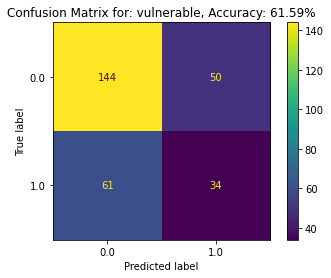

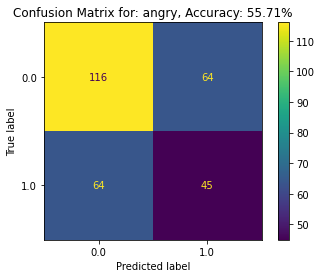

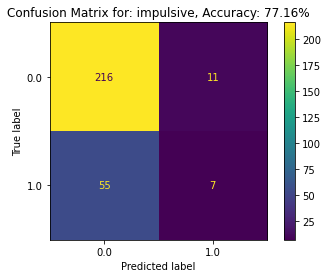

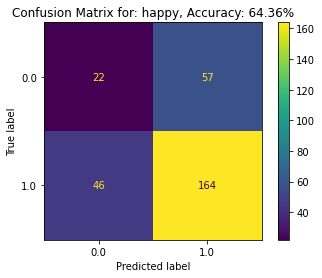

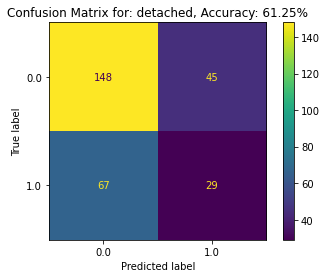

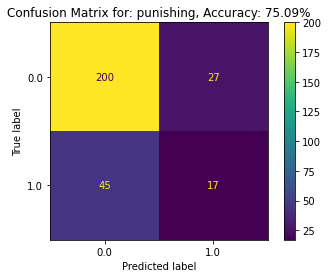

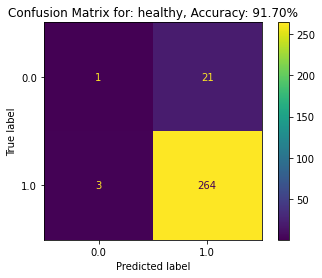

              precision    recall  f1-score   support

  vulnerable       0.40      0.36      0.38        95
       angry       0.41      0.41      0.41       109
   impulsive       0.39      0.11      0.18        62
       happy       0.74      0.78      0.76       210
    detached       0.39      0.30      0.34        96
   punishing       0.39      0.27      0.32        62
     healthy       0.93      0.99      0.96       267

   micro avg       0.67      0.62      0.65       901
   macro avg       0.52      0.46      0.48       901
weighted avg       0.64      0.62      0.62       901
 samples avg       0.71      0.69      0.66       901

AUC: 0.550


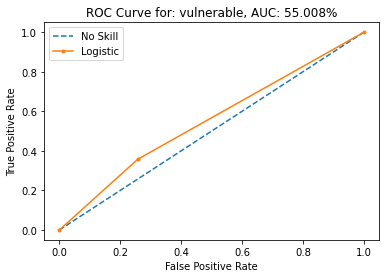

AUC: 0.529


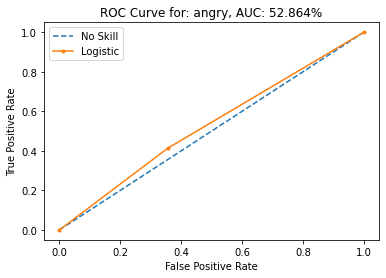

AUC: 0.532


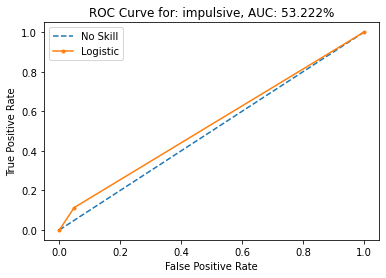

AUC: 0.530


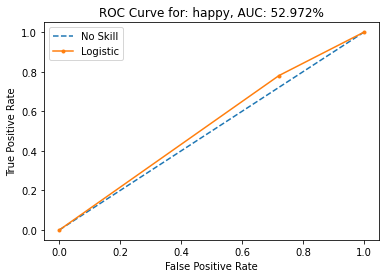

AUC: 0.534


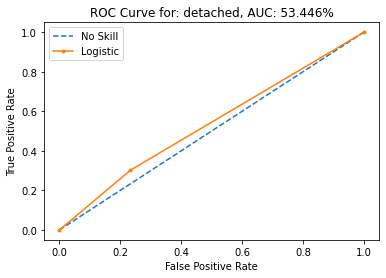

AUC: 0.578


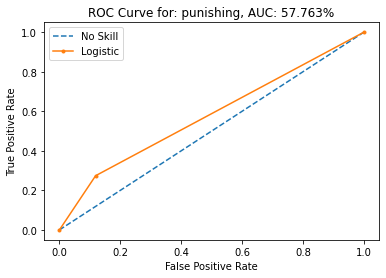

AUC: 0.517


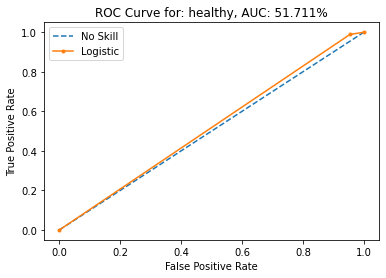

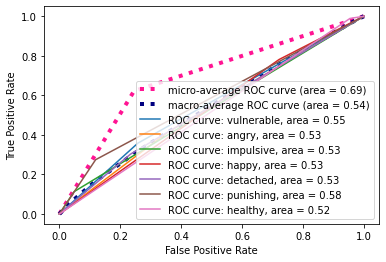

In [13]:
k=1

def multilabel_rnn_binary(padded_train_x, train_y, padded_test_x, test_y, padded_val_x, val_y):
    # train the multilabel model
    for i in range(k):
        # we train the model
        out, model = multilabel_model_binary(padded_train_x, train_y, padded_val_x, val_y)
        model.save("../plots/rnn/MLMs/BINARY/mlm_" + str(i) + '.h5')
        # Generate generalization metrics
        score = model.evaluate(padded_test_x, test_y, verbose=1)

        print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
        print(model.summary())

    accurs, preds = predict_schema_mlm_binary(padded_test_x, test_y)
    return accurs, preds

print("binary multilabel_rnn()")
accurs, preds = multilabel_rnn_binary(padded_train_x_binary, train_y_binary, padded_test_x_binary, test_y_binary,
                      padded_val_x_binary, val_y_binary)
test_y = test_y_binary
preds = preds.reshape(np.shape(preds)[0], 7)
get_mlm_results_binary(accurs, preds)

## BINARY Per-Schema Models

In [14]:
# load single models
def load_single_models(directory):
    single_models = []
    for i in range(7):
        model_name = '/schema_model_' + schemas[i]
        get_from = directory + model_name
        model = keras.models.load_model(get_from + '.h5')
        single_models.append(model)
    return single_models


# binary psm model
def perschema_models_binary(train_x, train_y, val_x, val_y):
    model = Sequential()
    e = Embedding(vocab_size, vec_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model.add(e)
    model.add(Bidirectional(LSTM(200)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['mean_absolute_error'])
    # summarize the model
    print(model.summary())
    # fit the model
    model.fit(train_x, train_y,
              validation_data=[val_x, val_y],
              batch_size=32,
              epochs=100,
              verbose=0,
              use_multiprocessing=True)
    return model


# generate BINARY predictions with the per-schema models
def predict_schema_psm_binary(test_text, test_labels, fixed=None):
    if fixed is None:
        all_preds = np.zeros((test_labels.shape[0], test_labels.shape[1], k))
        all_accurs = np.zeros((k, 7))
        for j in range(k):
            directory_name = "../plots/rnn/PSMs/BINARY/psm_" + str(j)
            preds = np.zeros(test_labels.shape)
            accurs = []
            single_models = load_single_models(directory_name)
            for i in range(7):
                model = single_models[i]
                out = model.predict(test_text)
                out = [round(x[0]) for x in out]
                preds[:, i] = out
                # accuracy between predictions and test labels
                accurs.append(accuracy_score(test_labels[:, i], out))
            all_preds[:, :, j] = preds
            all_accurs[j, :] = accurs
    else:
        directory_name = "../plots/rnn/PSMs/BINARY/psm_" + str(fixed)
        all_preds = np.zeros(test_labels.shape)
        all_accurs = []
        single_models = load_single_models(directory_name)
        for i in range(7):
            model = single_models[i]
            out = model.predict(test_text)
            out = [round(x[0]) for x in out]
            all_preds[:, i] = out
            all_accurs.append(round(accuracy_score(test_labels[:, i], out)))
    return all_accurs, all_preds

## BINARY Per-Schema results

In [15]:
def get_psm_results_binary(accurs, preds):
    print('Binary Model Testset Output')
    print(pd.DataFrame(data=accurs[0], index=schemas, columns=['estimate']))
    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(test_y, preds)
    # Plotting matrices: code
    for i, mat in enumerate(matrices):
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(test_y)).plot()
        plt.title('Confusion Matrix for: ' + str(schemas[i]) + ", Accuracy: " + "{:.2%}"
                  .format(accuracy_score(y_true=test_y[:, i], y_pred=preds[:, i])))
        plt.savefig("../plots/rnn/confusion_matrix_PSMs/confusion_matrix_" + schemas[i])
        plt.show()

    # Classification report
    report = classification_report(test_y, preds, target_names=schemas)
    print(report)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # ROC curve
    for i, schema in enumerate(schemas):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('AUC: %.3f' % roc_auc[i])
        # # generate a no skill prediction (majority class)
        ns_preds = [0 for _ in range(len(test_y[:, i]))]
        # # # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(test_y[:, i], ns_preds)
        # plot the roc curve for each schema model
        plt.title('ROC Curve for: ' + schema + ", AUC: {:.3%}"
                  .format(roc_auc[i]))
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(fpr[i], tpr[i], marker='.', label='Logistic')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # save the plot
        plt.savefig("../plots/rnn/roc_PSMs/roc_" + schema)
        # show the plot
        plt.show()

    # micro
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(schemas))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(schemas)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(schemas)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    # plot the roc curves for all models
    for j, schema in enumerate(schemas):
        plt.plot(fpr[j], tpr[j],
                 label='ROC curve: ' + schema + ', area = {1:0.2f}'
                 ''.format(j, roc_auc[j]))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # save the plot
    plt.savefig("../plots/rnn/roc_PSMs/roc_all")
    # show the plot
    plt.show()

    tpr_file = open('../plots/rnn/tpr_rnn.pkl', 'wb')
    pickle.dump(tpr, tpr_file)

    fpr_file = open('../plots/rnn/fpr_rnn.pkl', 'wb')
    pickle.dump(fpr, fpr_file)

    roc_auc_file = open('../plots/rnn/roc_auc_rnn.pkl', 'wb')
    pickle.dump(roc_auc, roc_auc_file)

## Run BINARY Per-Schema Model

binary perschema rnn()
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 400)               801600    
_________________________________________________________________
dropout_8 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 401       
Total params: 2,169,101
Trainable params: 802,001
Non-trainable params: 1,367,100
_________________________________________________________________
None
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 300)         

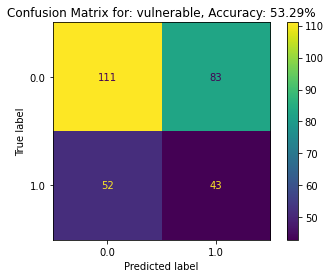

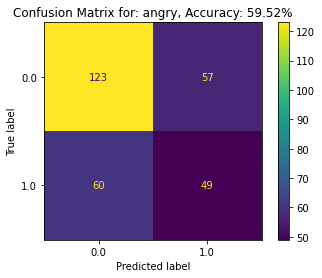

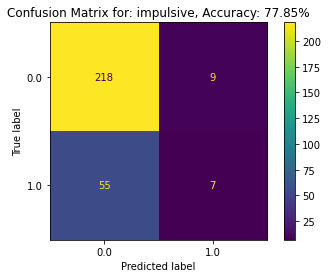

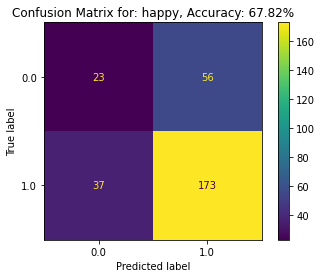

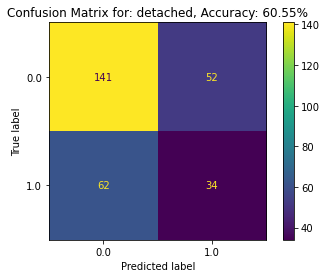

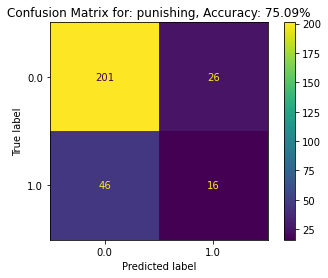

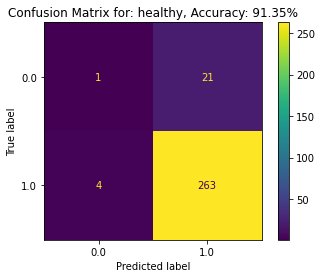

              precision    recall  f1-score   support

  vulnerable       0.34      0.45      0.39        95
       angry       0.46      0.45      0.46       109
   impulsive       0.44      0.11      0.18        62
       happy       0.76      0.82      0.79       210
    detached       0.40      0.35      0.37        96
   punishing       0.38      0.26      0.31        62
     healthy       0.93      0.99      0.95       267

   micro avg       0.66      0.65      0.65       901
   macro avg       0.53      0.49      0.49       901
weighted avg       0.64      0.65      0.64       901
 samples avg       0.69      0.72      0.66       901

AUC: 0.512


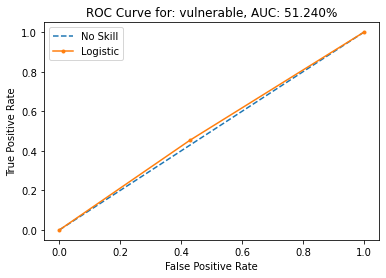

AUC: 0.566


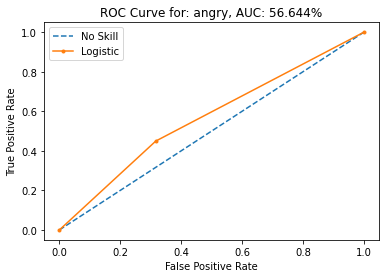

AUC: 0.537


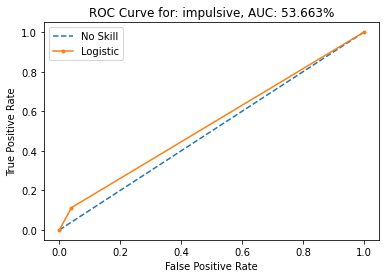

AUC: 0.557


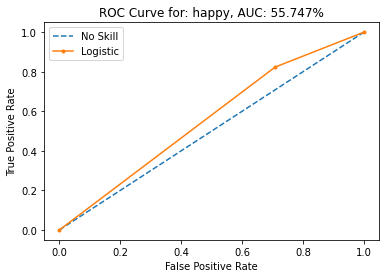

AUC: 0.542


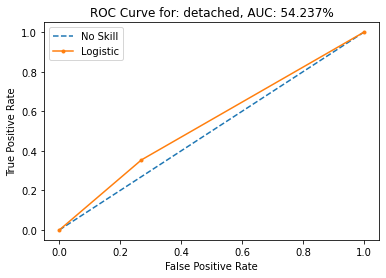

AUC: 0.572


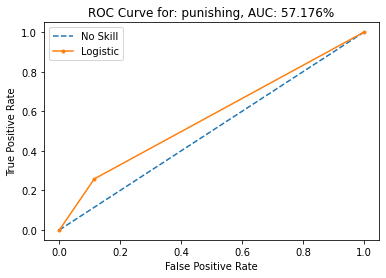

AUC: 0.515


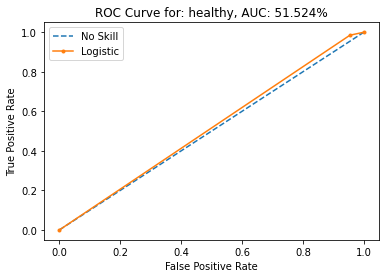

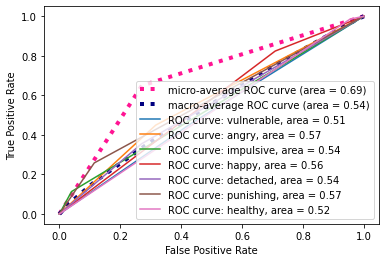

In [18]:
def perschema_rnn_binary(padded_train_x, train_y, padded_test_x, test_y, padded_val_x, val_y):
    # train the per schema models
    for j in range(k):
        directory_name = "../plots/rnn/PSMs/BINARY/psm_" + str(j)
        for i in range(7):
            train_label_schema = train_y[:, i]
            val_label_schema = val_y[:, i]
            model = perschema_models_binary(padded_train_x, train_label_schema, padded_val_x, val_label_schema)
            # we write trained models to files to free up working memory
            model_name = '/schema_model_' + schemas[i]
            save_model_under = directory_name + model_name
            model.save(save_model_under + '.h5')

    return predict_schema_psm_binary(padded_test_x, test_y)

print("binary perschema rnn()")
accurs, preds = perschema_rnn_binary(padded_train_x_binary, train_y_binary, padded_test_x_binary, test_y_binary,
                      padded_val_x_binary, val_y_binary)
test_y = test_y_binary
preds = preds.reshape(np.shape(preds)[0], 7)
get_psm_results_binary(accurs, preds)

## ORDINAL Per-Schema Models

In [25]:
def perschema_models_ordinal(train_x, train_y, val_x, val_y):
    model = Sequential()
    e = Embedding(vocab_size, vec_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model.add(e)
    model.add(Bidirectional(LSTM(vec_size)))
    model.add(Dropout(0.1))
    model.add(Dense(4, activation='softmax'))
    # compile the model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['mean_absolute_error'])
    # summarize the model
    print(model.summary())
    # fit the model
    model.fit(train_x, train_y,
              validation_data=[val_x, val_y],
              batch_size=32,
              epochs=10,
              verbose=0,
              use_multiprocessing=True)
    return model

# generate ORDINAL predictions with the per-schema models
def predict_schema_psm_ordinal(test_text, test_labels, fixed=None):
    if fixed is None:
        all_preds = np.zeros((test_labels.shape[0], test_labels.shape[1], k))
        all_gofs = np.zeros((k, 7))
        for j in range(k):
            directory_name = "../plots/rnn/PSMs/ORDINAL/psm_" + str(j)
            preds = np.zeros(test_labels.shape)
            gofs = []
            single_models = load_single_models(directory_name)
            for i in range(7):
                model = single_models[i]
                out = model.predict(test_text)
                out = [np.argmax(x) for x in out]
                preds[:, i] = out
                # spearman correlation between predictions and test labels
                gof, p = scipy.stats.spearmanr(out, test_labels[:, i])
                gofs.append(gof)
            all_preds[:, :, j] = preds
            all_gofs[j, :] = gofs
    else:
        directory_name = "../plots/rnn/PSMs/ORDINAL/psm_" + str(fixed)
        all_preds = np.zeros(test_labels.shape)
        all_gofs = []
        single_models = load_single_models(directory_name)
        for i in range(7):
            model = single_models[i]
            out = model.predict(test_text)
            out = [np.argmax(x) for x in out]
            all_preds[:, i] = out
            gof, p = scipy.stats.spearmanr(out, test_labels[:, i])
            all_gofs.append(gof)
    return all_gofs, all_preds

## ORDINAL Per-Schema Model

In [26]:
def get_psm_results_ordinal(gof, preds):
    #make a sum of all classification values
    gof_sum = np.sum(gof, axis=1)
    #sort sums
    gof_sum_sorted = np.sort(gof_sum)
    #pick element that is closest but larger than median (we have even number of elements)
    get_med_element = gof_sum_sorted[floor(k/2)]
    #get index of median
    gof_sum_med_idx = np.where(gof_sum == get_med_element)[0]
    #choose this as the final model to use in H2 and to report in the paper
    gof_out = gof[gof_sum_med_idx]
    output_psm = np.transpose(gof_out)

    print('RNN Multilabel Model Testset Output')
    print(pd.DataFrame(data=gof[0], index=schemas, columns=['estimate']))

## ORDINAL Multilabel Results

In [27]:
def get_results_ordinal(gof, preds):
    # #make a sum of all classification values
    # gof_sum = np.sum(gof, axis=1)
    # #sort sums
    # gof_sum_sorted = np.sort(gof_sum)
    # #pick element that is closest but larger than median (we have even number of elements)
    # get_med_element = gof_sum_sorted[floor(k/2)]
    # #get index of median
    # gof_sum_med_idx = np.where(gof_sum == get_med_element)[0]
    # #choose this as the final model to use in H2 and to report in the paper
    # gof_out = gof[gof_sum_med_idx]
    # output_psm = np.transpose(gof_out)

    print('RNN Multilabel Model Testset Output')
    print(pd.DataFrame(data=gof[0], index=schemas, columns=['estimate']))

## Run ORDINAL Per-Schema model

In [28]:
k=1
def perschema_rnn_ordinal(padded_train_x, train_y, padded_test_x, test_y, padded_val_x, val_y):
    # train the per schema models
    for j in range(k):
        directory_name = "../plots/rnn/PSMs/ORDINAL/psm_" + str(j)
        for i in range(7):
            train_label_schema = np_utils.to_categorical(train_y[:, i], num_classes=4)
            val_label_schema = np_utils.to_categorical(val_y[:, i], num_classes=4)
            model = perschema_models_ordinal(padded_train_x, train_label_schema, padded_val_x, val_label_schema)
            # we write trained models to files to free up working memory
            model_name = '/schema_model_' + schemas[i]
            save_model_under = directory_name + model_name
            model.save(save_model_under + '.h5')

    accurs, preds = predict_schema_psm_ordinal(padded_test_x, test_y)
    return accurs, preds

print("ordinal perschema_rnn()")
accurs, preds = perschema_rnn_ordinal(padded_train_x_ordinal, train_y_ordinal, padded_test_x_ordinal, test_y_ordinal
                                      , padded_val_x_ordinal, val_y_ordinal)

test_y = test_y_binary
preds = preds.reshape(np.shape(preds)[0], 7)
get_results_ordinal(accurs, preds)

ordinal perschema_rnn()
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 500, 300)          1367100   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 600)               1442400   
_________________________________________________________________
dropout_22 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 2404      
Total params: 2,811,904
Trainable params: 1,444,804
Non-trainable params: 1,367,100
_________________________________________________________________
None
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 500, 300)    